In [94]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import linear_model
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter
import pylab as P

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40227 entries, 0 to 40226
Data columns (total 12 columns):
neighbourhood_cleansed    40227 non-null object
room_type                 40227 non-null object
accommodates              40227 non-null int64
bedrooms                  40170 non-null float64
beds                      40158 non-null float64
price                     40227 non-null object
availability_30           40227 non-null int64
number_of_reviews         40227 non-null int64
review_scores_rating      30420 non-null float64
instant_bookable          40227 non-null object
cancellation_policy       40227 non-null object
reviews_per_month         31150 non-null float64
dtypes: float64(4), int64(3), object(5)
memory usage: 3.7+ MB
40227


### Load Data

In [ ]:
listing='C:\Users\\12815\\Desktop\\DataSet\\listings.csv'
cols = ['price',
        'accommodates',
        'bedrooms',
        'beds',
        'neighbourhood_cleansed',
        'room_type',
        'cancellation_policy',
        'instant_bookable',
        'reviews_per_month',
        'number_of_reviews',
        'availability_30',
        'review_scores_rating',
#         'property_type',
#         'bed_type',
#         'cleaning_fee',
        ]
#read the file into a dataframe
df=pd.read_csv(listing, usecols=cols)
df.info()
df.describe()
print len(df.index)

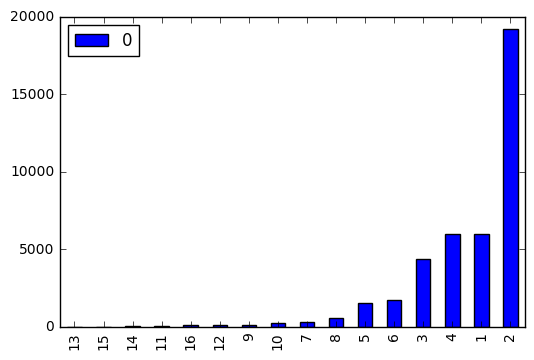

In [66]:

nb_counts_accomodates = Counter(df.accommodates)
nb_counts_neighbourhood_cleansed=Counter(df.neighbourhood_cleansed)

# print nb_counts
tdf = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by=0)
tdf.plot(kind='bar')

### Data Cleaning

In [67]:
len(df[(df.number_of_reviews==0) &(pd.isnull(df.number_of_reviews)==False) 
       &(pd.isnull(df.reviews_per_month)==False)].index)

0

In [68]:
len(df[(df.number_of_reviews != 0) & (pd.isnull(df.number_of_reviews) == False)
       & (pd.isnull(df.reviews_per_month) == True)].index)

69

In [69]:
df['reviews_per_month'].fillna(0, inplace=True)

In [70]:
len(df[(df.number_of_reviews != 0) & (pd.isnull(df.number_of_reviews) == False)
       & (pd.isnull(df.reviews_per_month) == True)].index)

0

In [71]:
df = df[df.bedrooms != 0]
df = df[df.beds != 0]
df = df[df.price != 0]
df = df.dropna(axis=0)

In [72]:
len(df.index)

27735

In [73]:

df = df[df.bedrooms == 1]
len(df.index)

22833

In [74]:
# remove the $ from the price and convert to float
df['price'] = df['price'].replace('[\$,)]','',  \
        regex=True).replace('[(]','-', regex=True).astype(float)
df.price.head(5)

0     75.0
1    117.0
2     89.0
4    200.0
6    119.0
Name: price, dtype: float64

In [75]:
# get feature encoding for categorical variables
n_dummies = pd.get_dummies(df.neighbourhood_cleansed)
rt_dummies = pd.get_dummies(df.room_type)
xcl_dummies = pd.get_dummies(df.cancellation_policy)
# convert boolean column to a single boolean value indicating whether this listing has instant booking available
ib_dummies = pd.get_dummies(df.instant_bookable, prefix="instant")
ib_dummies = ib_dummies.drop('instant_f', axis=1)
# replace the old columns with our new one-hot encoded ones
alldata = pd.concat((df.drop(['neighbourhood_cleansed', \
    'room_type', 'cancellation_policy', 'instant_bookable'], axis=1), \
    n_dummies.astype(int), rt_dummies.astype(int), \
    xcl_dummies.astype(int), ib_dummies.astype(int)), \
    axis=1)
allcols = alldata.columns
alldata.head(5)

,accommodates,bedrooms,beds,price,availability_30,number_of_reviews,review_scores_rating,reviews_per_month,Allerton,Arden Heights,...,Woodlawn,Woodside,Entire home/apt,Private room,Shared room,flexible,moderate,strict,super_strict_30,instant_t
0,2,1.0,1.0,75.0,4,145,92.0,2.87,0,0,...,0,0,1,0,0,0,0,1,0,0
1,5,1.0,2.0,117.0,3,50,94.0,4.27,0,0,...,0,0,1,0,0,0,0,1,0,0
2,2,1.0,1.0,89.0,3,43,95.0,1.81,0,0,...,0,0,0,1,0,1,0,0,0,0
4,4,1.0,1.0,200.0,8,1,100.0,1.00,0,0,...,0,0,1,0,0,1,0,0,0,0
6,1,1.0,1.0,119.0,4,1,89.0,0.02,0,0,...,0,0,0,1,0,0,0,1,0,0


### Compare with Linear Regression

got error 21.73
got error 21.63
got error 25.82
got error 31.91
got error 21.38
got error 22.38


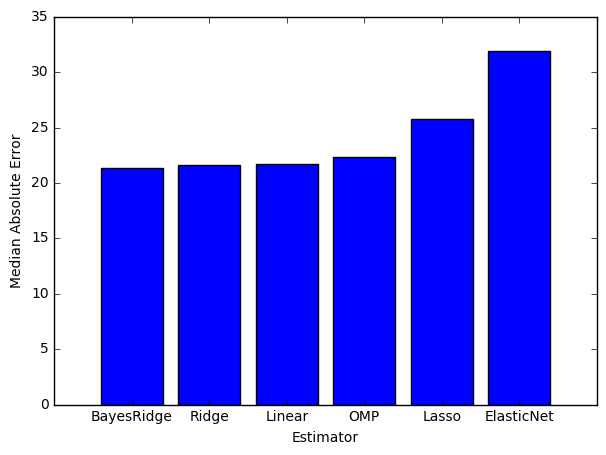

In [76]:
rs = 1
ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit() ]
ests_labels = np.array(['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'BayesRidge', 'OMP'])
errvals = np.array([])

X_train, X_test, y_train, y_test = train_test_split(alldata.drop(['price'], axis=1),
                                                    alldata.price, test_size=0.2, random_state=20)

for e in ests:
    e.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test))
    print "got error %0.2f" % this_err
    errvals = np.append(errvals, this_err)

pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(7,5))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')

### Tuning the hyperparameters

In [89]:
n_est = 300


tuned_parameters = {
    "n_estimators": [300, 500, 800],
    "max_depth" : [ 3, 4 ],
    "learning_rate": [ 0.01,0.02],
    "min_samples_split" : [ 2],
    "loss" : [ 'ls', 'lad' ]
}

gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gbr, cv=3, param_grid=tuned_parameters,
        scoring='median_absolute_error')
preds = clf.fit(X_train, y_train)
best = clf.best_estimator_
best

C:\Users\12815\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\12815\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\12815\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\12815\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\128

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.02, loss='lad', max_depth=4,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=800, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [90]:

abs(clf.best_score_)

17.417765866269733

###  Learning Curve

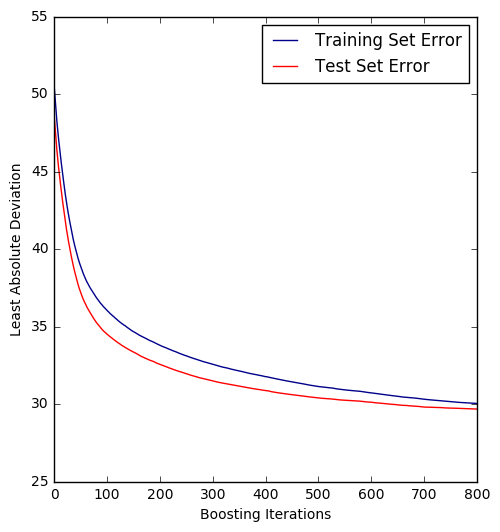

In [92]:
# plot error for each round of boosting
n_est=800
test_score = np.zeros(n_est, dtype=np.float64)

train_score = best.train_score_
for i, y_pred in enumerate(best.staged_predict(X_test)):
    test_score[i] = best.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(n_est), train_score, 'darkblue', label='Training Set Error')
plt.plot(np.arange(n_est), test_score, 'red', label='Test Set Error')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Least Absolute Deviation')